# Problem Framing: Hospital Billing Prediction

##  Objective
Predict the total **hospital billing amount** using only information available **at or before admission** to enable upfront cost estimates for patients and insurers.

##  Dataset
- **Source**: Synthetic hospital admissions dataset from [OpenDataBay](https://www.opendatabay.com/data/synthetic/953c80ef-162d-467b-ae1c-867d0f9c490d)  
- **Note**: For reproducibility, the data has been downloaded and stored in this project’s `data/` directory as `hospital_admissions.csv`.

##  Problem Type & Target
- **Type**: Supervised Regression  
- **Target Variable**: `Billing_Amount` (continuous, in local currency)

##  Input Features (Admission-Time Only)
To prevent data leakage, features are limited to those known **at the time of admission**:

- **Demographics**: Age, Gender, Blood Type  
- **Clinical**: Primary Medical Condition, Admission Medication, Test Results  
- **Administrative**: Admission Type, Doctor, Hospital, Insurance Provider, Room Number  
- **Temporal**: `Date of Admission` → engineered into day of week, month, or season  

>  **Excluded**: `Discharge Date` and derived `Length of Stay` — these are **not available at prediction time** and would cause **temporal leakage**.

##  Evaluation Strategy
- **Primary Metrics**: RMSE, MAE  
- **Baselines**:  
  - Global mean billing amount  
  - Mean billing per medical condition  
- **Validation**: Time-based train/test split (e.g., train on admissions before 2024, test on 2024+) to mimic real-world deployment

##  Key Considerations
- **No data leakage**: Strictly admission-time features only.  
- **Fairness**: Monitor prediction bias across insurance providers, hospitals, and demographic groups.  
- **Interpretability**: Stakeholders require transparent, auditable predictions.  
- **Clinical relevance**: Billing should correlate with care complexity—not arbitrary attributes like blood type.

## 1. Data Import

* The dataset is hosted on my GitHub repository. To ensure direct and reliable access in this notebook, the file is loaded using the **raw GitHub URL** (not the standard GitHub page link).

In [111]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To convert a GitHub file link into a raw file link, you typically replace the part of the URL that says github.com and the path to the file with raw.githubusercontent.com, and remove the blob/ segment from the URL.
# E.g: 

# https://github.com/username/repo/blob/branch/path/to/file.ext

# To:
# https://raw.githubusercontent.com/username/repo/branch/path/to/file.ext



url = "https://raw.githubusercontent.com/Rooney-tech/Machine-Learning/main/Linear%20regression/Data/healthcare_dataset.csv"
hosp_admisn = pd.read_csv(url)

hosp_admisn.head()


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Cathy Small,51,Female,O-,Asthma,12/23/2023,Wendy Glenn,"Brown, and Jones Weaver",Blue Cross,48661.611230,401,Elective,1/19/2024,Ibuprofen,Normal
1,Kathryn Stewart,58,Female,O+,Arthritis,5/12/2022,Vanessa Newton,Clark-Mayo,Aetna,7607.082452,327,Urgent,6/10/2022,Lipitor,Inconclusive
2,Cathy Small,51,Female,O-,Asthma,12/23/2023,Wendy Glenn,"Brown, and Jones Weaver",Blue Cross,65730.288807,401,Emergency,1/19/2024,Ibuprofen,Normal
3,Eileen Thompson,59,Male,A+,Asthma,8/2/2021,Donna Martinez MD,and Sons Smith,Aetna,50636.270799,119,Urgent,8/12/2021,Lipitor,Inconclusive
4,Luke Burgess,34,Female,A-,Hypertension,3/4/2021,Justin Moore Jr.,Houston PLC,Blue Cross,28593.470604,260,Elective,3/14/2021,Aspirin,Abnormal


## 2. Exploratory Data Analysis.

### 2.1 About the data

In [112]:
hosp_admisn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                65000 non-null  object 
 1   Age                 65000 non-null  int64  
 2   Gender              65000 non-null  object 
 3   Blood Type          65000 non-null  object 
 4   Medical Condition   65000 non-null  object 
 5   Date of Admission   65000 non-null  object 
 6   Doctor              65000 non-null  object 
 7   Hospital            65000 non-null  object 
 8   Insurance Provider  65000 non-null  object 
 9   Billing Amount      65000 non-null  float64
 10  Room Number         65000 non-null  int64  
 11  Admission Type      65000 non-null  object 
 12  Discharge Date      65000 non-null  object 
 13  Medication          65000 non-null  object 
 14  Test Results        61750 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 7.4

### 2.2  Data Type & Completeness Overview

-  **No column contains null (missing) values.**  
-  **Numeric columns**:  
  - `'Age'` and `'Room Number'` are stored as integers.  
  - `'Billing Amount'` is stored as a float (appropriate for currency).  
-  **Categorical/text columns**:  
  - All other columns are of `object` (non-numeric) data type.  
-  **Date columns require conversion**:  
  - `'Date of Admission'` and `'Discharge Date'` are currently stored as strings (`object`), **not datetime**.  
  - These must be converted to `datetime` format for temporal feature engineering and time-based validation.  


### 2.2.1 Conversion of '`Date of Admission`' and '`Discharge Date`' to datetime format.

In [113]:
hosp_admisn['Date of Admission'] =hosp_admisn['Date of Admission'].astype(dtype='datetime64[ns]')
hosp_admisn['Discharge Date'] = hosp_admisn['Discharge Date'].astype(dtype='datetime64[ns]')
hosp_admisn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                65000 non-null  object        
 1   Age                 65000 non-null  int64         
 2   Gender              65000 non-null  object        
 3   Blood Type          65000 non-null  object        
 4   Medical Condition   65000 non-null  object        
 5   Date of Admission   65000 non-null  datetime64[ns]
 6   Doctor              65000 non-null  object        
 7   Hospital            65000 non-null  object        
 8   Insurance Provider  65000 non-null  object        
 9   Billing Amount      65000 non-null  float64       
 10  Room Number         65000 non-null  int64         
 11  Admission Type      65000 non-null  object        
 12  Discharge Date      65000 non-null  datetime64[ns]
 13  Medication          65000 non-null  object    

###  Dataset Structure After Type Conversion

The dataset contains **55,500 admission records** with **15 columns** and **mis sing values in the `Test Results`**.

- **Datetime (2)**:  
  - `Date of Admission`  
  - `Discharge Date`  (converted from string)

- **Numeric (3)**:  
  - `Age` (`int64`)  
  - `Room Number` (`int64`)  
  - `Billing Amount` (`float64`)

- **Categorical / Text (10)**:  
  - `Name`, `Gender`, `Blood Type`, `Medical Condition`, `Doctor`, `Hospital`,  
    `Insurance Provider`, `Admission Type`, `Medication`, `Test Results`

#### Dataset Reduction

To optimize memory usage and streamline modeling, we retain only the most relevant features for predicting **`Billing Amount`**. This reduces noise, improves training speed, and minimizes the risk of including spurious or non-actionable variables.

Based on domain knowledge and preliminary analysis, the following admission-time features are selected as the strongest predictors:

- **`Age`**  
- **`Medical Condition`**  
- **`Admission Type`**  
- **`Hospital`**  
- **`Test Results`**  
- **`Medication`**

>  *Rationale*: These variables reflect patient acuity, care setting, and clinical context—all of which directly influence resource utilization and billing. Features like `Name`, `Blood Type`, `Gender`, and `Discharge Date` are excluded due to irrelevance, ethical considerations, or risk of data leakage.

In [114]:
# Drop columns
cols = ['Billing Amount','Age','Medical Condition','Admission Type','Hospital']
admissions = hosp_admisn[cols]
admissions.head()

,Billing Amount,Age,Medical Condition,Admission Type,Hospital
0,48661.611230,51,Asthma,Elective,"Brown, and Jones Weaver"
1,7607.082452,58,Arthritis,Urgent,Clark-Mayo
2,65730.288807,51,Asthma,Emergency,"Brown, and Jones Weaver"
3,50636.270799,59,Asthma,Urgent,and Sons Smith
4,28593.470604,34,Hypertension,Elective,Houston PLC


####  Extract categorical variables and examine their data quality.

In [115]:
print('Medical Conditions: ', admissions['Medical Condition'].unique())
print('Admission Types   : ', admissions['Admission Type'].unique())
print('Hospitals         : ', len(admissions['Hospital'].unique()))



Medical Conditions:  ['Asthma' 'Arthritis' 'Hypertension' 'Diabetes' 'Obesity' 'Cancer']
Admission Types   :  ['Elective' 'Urgent' 'Emergency']
Hospitals         :  27


* Since there is no much information about the hospitals, whether urban, teaching, referral or rural, it will not affect our predictions and might add noise. Therefore, its dropped as a key variable.


In [116]:
admissions = admissions.copy()
col = ['Hospital']
for cl in col:
    if cl in admissions.columns:
        admissions.drop(columns=cl, inplace=True)

admissions.head()

,Billing Amount,Age,Medical Condition,Admission Type
0,48661.611230,51,Asthma,Elective
1,7607.082452,58,Arthritis,Urgent
2,65730.288807,51,Asthma,Emergency
3,50636.270799,59,Asthma,Urgent
4,28593.470604,34,Hypertension,Elective


### 2.3 Data Visualization

We use a **pairplot** to explore pairwise relationships among numerical features. This helps us:
- Visually assess correlations between variables,  
- Identify potential **multicollinearity** early in the pipeline,  
- Inform feature selection—e.g., by removing one of two highly correlated predictors to improve model stability and interpretability.

In [117]:
# Import visualization libraries.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

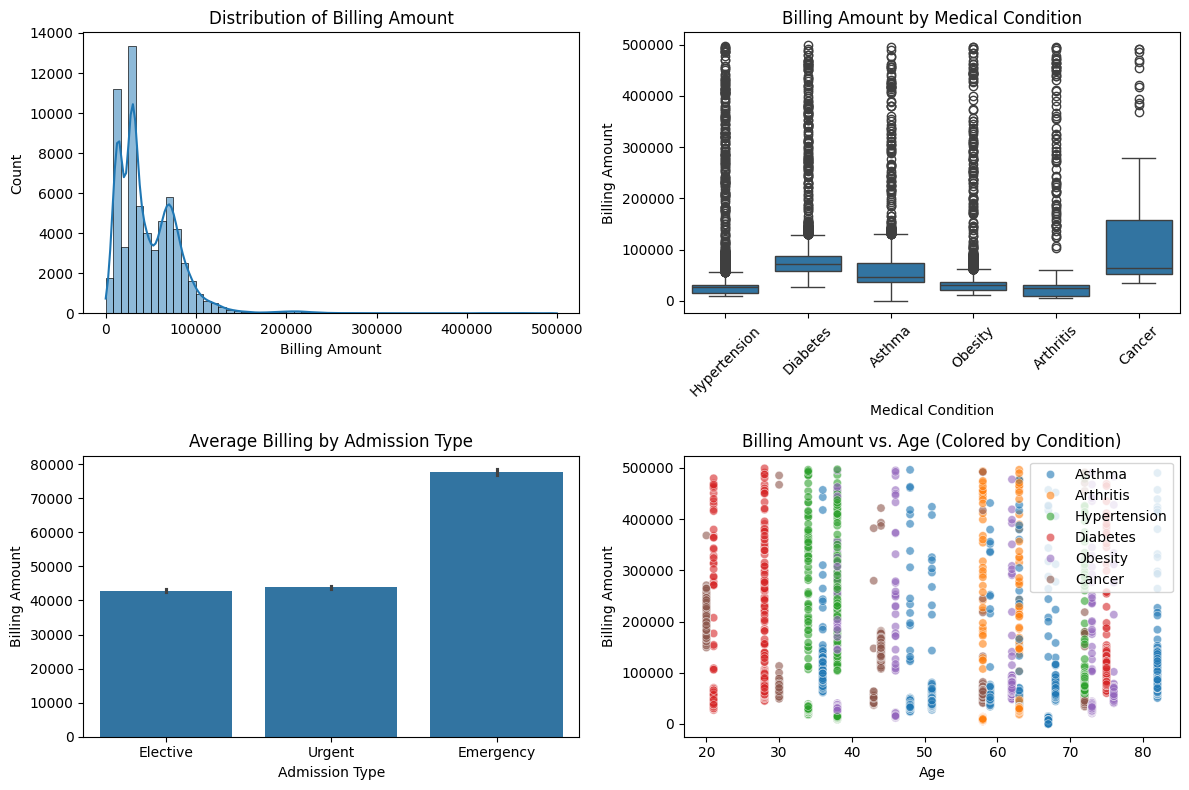

In [118]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Histogram + KDE
sns.histplot(data=admissions, x='Billing Amount', kde=True, bins=60, ax=ax[0,0])
ax[0,0].set_title('Distribution of Billing Amount')

# Boxplot by Medical Condition
sns.boxplot(data=admissions, x='Medical Condition', y='Billing Amount',
            order=admissions['Medical Condition'].value_counts().index, ax=ax[0,1])
ax[0,1].tick_params(axis='x', rotation=45)
ax[0,1].set_title('Billing Amount by Medical Condition')

# Barplot by Admission Type
sns.barplot(data=admissions, x='Admission Type', y='Billing Amount',
            order=['Elective', 'Urgent', 'Emergency'], ax=ax[1,0])
ax[1,0].set_title('Average Billing by Admission Type')

# Scatterplot Age vs Billing Amount
sns.scatterplot(data=admissions, x='Age', y='Billing Amount',
                hue='Medical Condition', alpha=0.6, ax=ax[1,1])
ax[1,1].set_title('Billing Amount vs. Age (Colored by Condition)')
ax[1,1].legend(loc = 'upper right', bbox_to_anchor = (1,1))

plt.tight_layout()
plt.show()

#### Feedback.

- The distribution of `Billing Amount` is **right-skewed**, as shown in the first plot.  
  The boxplot further highlights the presence of substantial outliers in `Billing Amount`.  
  These will be addressed using the **Interquartile Range (IQR)** method.

- There appears to be no clear relationship between `Age` and `Billing Amount`.  
  Nevertheless, `Age` may still be included in the model to evaluate its potential effect.

#### Outlier Removal

In [119]:
# Five-number summary
min_val, q1, median, q3, max_val = np.quantile(admissions['Billing Amount'], q=[0, 0.25, 0.5, 0.75, 1])

print(f"Min: {min_val:.2f}")
print(f"Q1: {q1:.2f}")
print(f"Median: {median:.2f}")
print(f"Q3: {q3:.2f}")
print(f"Max: {max_val:.2f}")

# Interquartile range
iqr = q3-q1
print(f"Interquartile-range: {iqr}")

lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr

print('\n')
print(f"IQR: {iqr:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

# Extract rows with outliers
outlier_df = admissions[(admissions['Billing Amount']>=upper_bound) | (admissions['Billing Amount']<=lower_bound)]
print(f"\nTotal rows with outlier values: {outlier_df.shape[0]}")

# inlier dataset
admissions = admissions[(admissions['Billing Amount']>=lower_bound)&(admissions['Billing Amount']<=upper_bound)].copy()




Min: 100.18
Q1: 25036.55
Median: 37165.58
Q3: 69449.60
Max: 499301.10
Interquartile-range: 44413.050190587965


IQR: 44413.05
Lower bound: -41583.03
Upper bound: 136069.17

Total rows with outlier values: 1503


### Second plot to check outliers

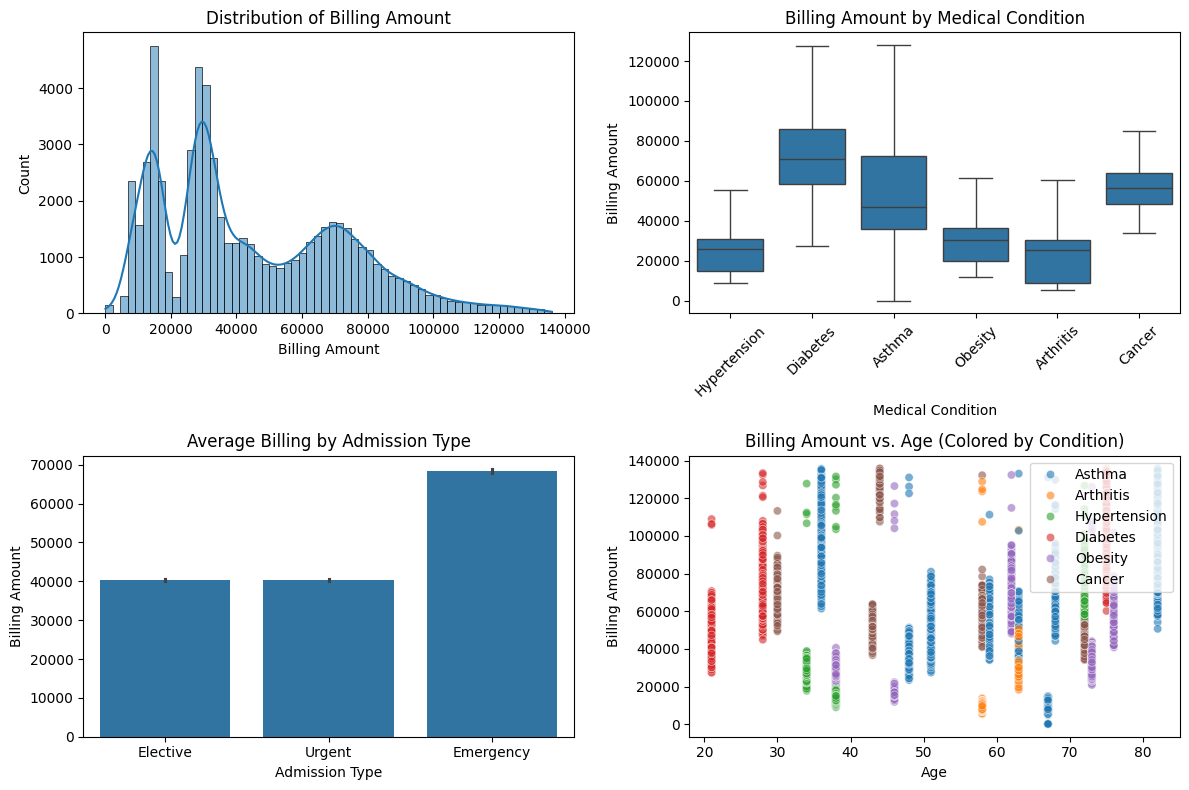

In [120]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Histogram + KDE
sns.histplot(data=admissions, x='Billing Amount', kde=True, bins=60, ax=ax[0,0])
ax[0,0].set_title('Distribution of Billing Amount')

# Boxplot by Medical Condition
sns.boxplot(data=admissions, x='Medical Condition', y='Billing Amount',
            order=admissions['Medical Condition'].value_counts().index, showfliers = False, ax=ax[0,1])
ax[0,1].tick_params(axis='x', rotation=45)
ax[0,1].set_title('Billing Amount by Medical Condition')

# Barplot by Admission Type
sns.barplot(data=admissions, x='Admission Type', y='Billing Amount',
            order=['Elective', 'Urgent', 'Emergency'], ax=ax[1,0])
ax[1,0].set_title('Average Billing by Admission Type')

# Scatterplot Age vs Billing Amount
sns.scatterplot(data=admissions, x='Age', y='Billing Amount',
                hue='Medical Condition', alpha=0.6, ax=ax[1,1])
ax[1,1].set_title('Billing Amount vs. Age (Colored by Condition)')
ax[1,1].legend(loc = 'upper right', bbox_to_anchor = (1,1))

plt.tight_layout()
plt.show()

## Data Preprocessing.

* Now that the data quality issues has been addressed, its time to prepare the data for OLS modelling using sklearn.


#### 3.1. First, we import the libraries.

In [ ]:
from sklearn.model_selection import train_test_split

### Extract Response and Target variables from the data.

In [122]:
y = admissions['Billing Amount']
X = admissions.drop(columns =['Billing Amount'])

### 3.2 Split the data into Training and and Test chuncks. 

In [123]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size= 0.3,random_state=1)
splits = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
}

# Loop through and print shapes
for name, data in splits.items():
    print(f"{name} shape: {data.shape}")


X_train shape: (44447, 3)
X_test shape: (19050, 3)
y_train shape: (44447,)
y_test shape: (19050,)


### Encode Non‑Numeric Variables
- The `Medical Condition` and `Admission Type` columns in the predictors DataFrame are **categorical features**.  
- These variables require transformation using **OneHotEncoder** to convert them into a suitable numeric format for modeling.

In [124]:
# Import encoding methods
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


* Encoding `Medical Condition` and `Admission Type`

In [134]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

categorical_features = ['Medical Condition', 'Admission Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat',ohe,categorical_features )
        
    ], remainder='passthrough'
)

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# View the dense matrix
X_train_enc_df = pd.DataFrame(X_train_enc,columns=preprocessor.get_feature_names_out(),index =X_train.index).head()
X_test_enc_df = pd.DataFrame(X_test_enc,columns=preprocessor.get_feature_names_out(),index =X_test.index).head()

print('X_train_encoded dataframe')
display(X_train_enc_df.head())
print('\n X_test_encoded dataframe')
display(X_test_enc_df.head())

X_train_encoded dataframe


,cat__Medical Condition_Arthritis,cat__Medical Condition_Asthma,cat__Medical Condition_Cancer,cat__Medical Condition_Diabetes,cat__Medical Condition_Hypertension,cat__Medical Condition_Obesity,cat__Admission Type_Elective,cat__Admission Type_Emergency,cat__Admission Type_Urgent,remainder__Age
22211,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,51.0
27503,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,67.0
45274,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,34.0
2414,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,58.0
41916,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,28.0



 X_test_encoded dataframe


,cat__Medical Condition_Arthritis,cat__Medical Condition_Asthma,cat__Medical Condition_Cancer,cat__Medical Condition_Diabetes,cat__Medical Condition_Hypertension,cat__Medical Condition_Obesity,cat__Admission Type_Elective,cat__Admission Type_Emergency,cat__Admission Type_Urgent,remainder__Age
27942,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,34.0
20692,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,28.0
31320,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,58.0
29751,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,67.0
60640,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,28.0
